# Potato Disease Classification

> Dataset: https://www.kaggle.com/arjuntejaswi/plant-village

#### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

2025-05-06 21:52:55.756795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Set all the Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

#### Import data into tensorflow dataset object
> 1. We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

In [13]:
32 * 68            #(BATCH_SIZE * len)

2176

In [15]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 2 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 2 0]


2025-05-06 21:53:10.715607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Visualize some of the images from our dataset

2025-05-06 21:53:11.768932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


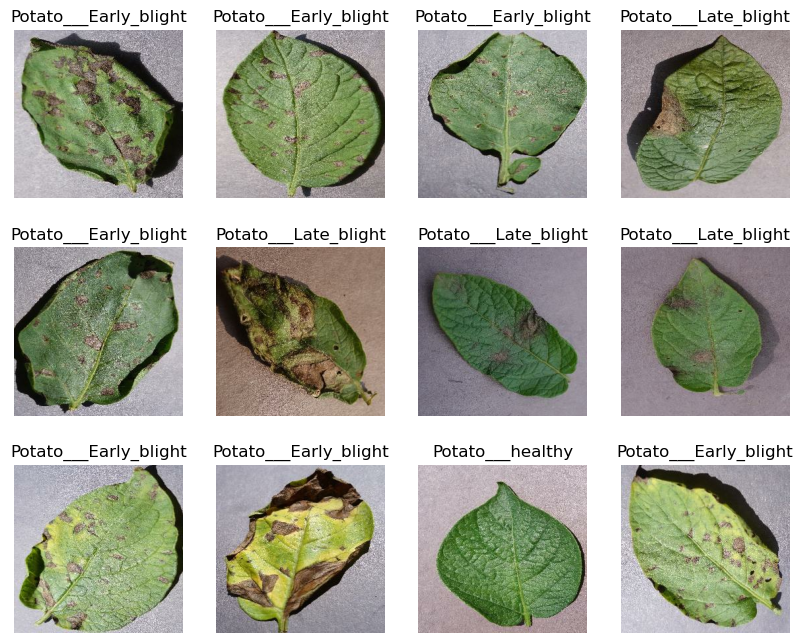

In [18]:
plt.figure(figsize=(10,8))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]]) # provide the class name
        plt.axis('off')    # it just hide the X and Y label scale

## Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

    1. Training: Dataset to be used while training
    2. Validation: Dataset to be tested against while training
    3. Test: Dataset to be tested against after we trained a model

In [21]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [23]:
# Train dataset

train_ds = dataset.take(54)
len(train_ds)

54

In [26]:
# Test dataset

test_ds = dataset.skip(54)
len(test_ds)


14

In [28]:

val_size = 0.1
len(test_ds)*val_size

1.4000000000000001

In [30]:
# validation dataset

val_ds = test_ds.take(6)
len(val_ds)

6

In [32]:
# Actual test dataset

test_ds = test_ds.skip(6)
len(test_ds)

8

### Now create a wrapper class/funtion for all of the above

In [35]:

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [39]:
len(train_ds)

54

In [41]:
len(test_ds)

8

In [43]:
len(val_ds)

6

### Cache, Shuffle, and Prefetch the Dataset

In [46]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


## Building the Model
### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [50]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


## Data Augmentation

    1. Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
    2. modification of Image: Rotation, increase contrast,zoom,Horizontal Flip 

In [53]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

## Model Architecture

    1. We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [57]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 3

# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
    
#     layers.Conv2D(32, kernel_size = (3,3),activation = 'relu', input_shape = input_shape),
#     layers.MaxPool2D((2,2)),

#     layers.Conv2D(64, kernel_size=(3,3),activation = 'relu'),
#     layers.MaxPool2D((2,2)),


#     layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
#     layers.MaxPool2D((2,2)),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     # now flatten the Neural Network
#     layers.Flatten(),
#     layers.Dense(64,activation = 'relu'),
#     layers.Dense(n_classes,activation = 'softmax')    # n_class already defined means 3 dataset in our dataset
      
# ])


n_classes = 3
CHANNELS = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)





/Users/hirdeshpal/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [63]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
)

In [65]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.4471 - loss: 0.9533 - val_accuracy: 0.5781 - val_loss: 0.7646
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6865 - loss: 0.6511 - val_accuracy: 0.8281 - val_loss: 0.4098
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8629 - loss: 0.3531 - val_accuracy: 0.8802 - val_loss: 0.3310
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8922 - loss: 0.2719 - val_accuracy: 0.9479 - val_loss: 0.1772
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9232 - loss: 0.1739 - val_accuracy: 0.9375 - val_loss: 0.2047
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9422 - loss: 0.1552 - val_accuracy: 0.9583 - val_loss: 0.1187
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9592 - loss: 0.1138 - val_accuracy: 0.7396 - val_loss: 0.8812
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9488 - loss: 0.1525 - val_accuracy: 0.9740 - v

In [67]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 649ms/step - accuracy: 0.9699 - loss: 0.0593



#### You can see above that we get 96.99% accuracy for our test dataset. This is pretty good accuracy.


In [78]:
# scores is just a list containing loss and accuracy value

scores

[0.07156217098236084, 0.96875]

### Plotting the Accuracy and Loss Curves

In [85]:
#  documentation on history object: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History


history




In [87]:


history.params



{'verbose': 1, 'epochs': 10, 'steps': 54}

In [89]:


history.history.keys()



dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


#### loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch


In [98]:


type(history.history['loss'])




list

In [100]:

len(history.history['loss'])



10

In [102]:

history.history['loss'][:5] # show loss for first 5 epochs



[0.8865277171134949,
 0.5576506853103638,
 0.32323893904685974,
 0.24244576692581177,
 0.1511307954788208]

In [104]:
	

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



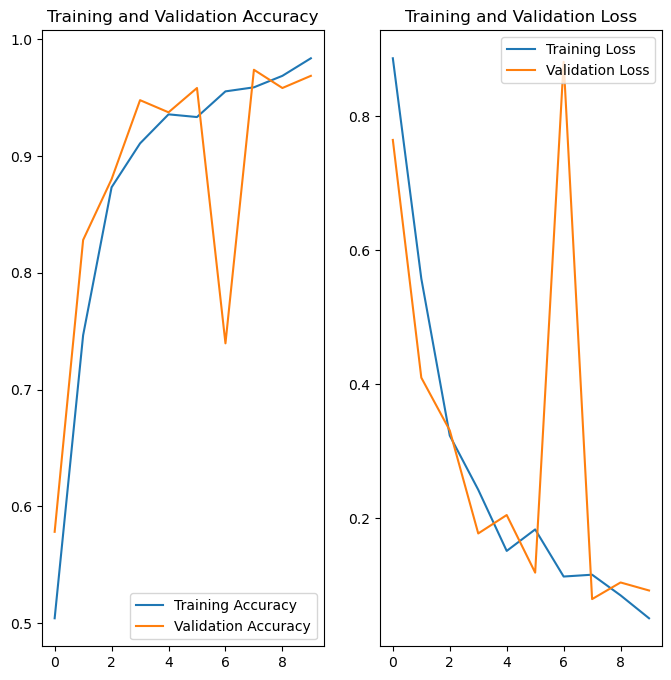

In [108]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()




## Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Potato___Early_blight


2025-05-06 22:23:53.957078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


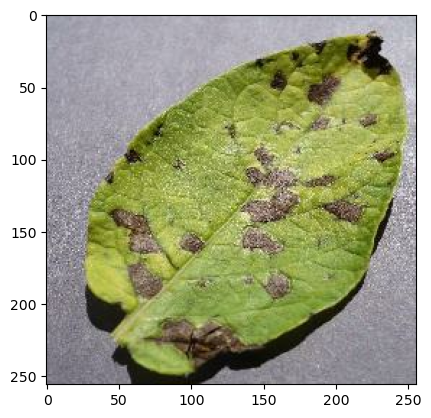

In [112]:


import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])



## a function for inference

In [116]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



#### Now run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2025-05-06 22:25:00.447524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


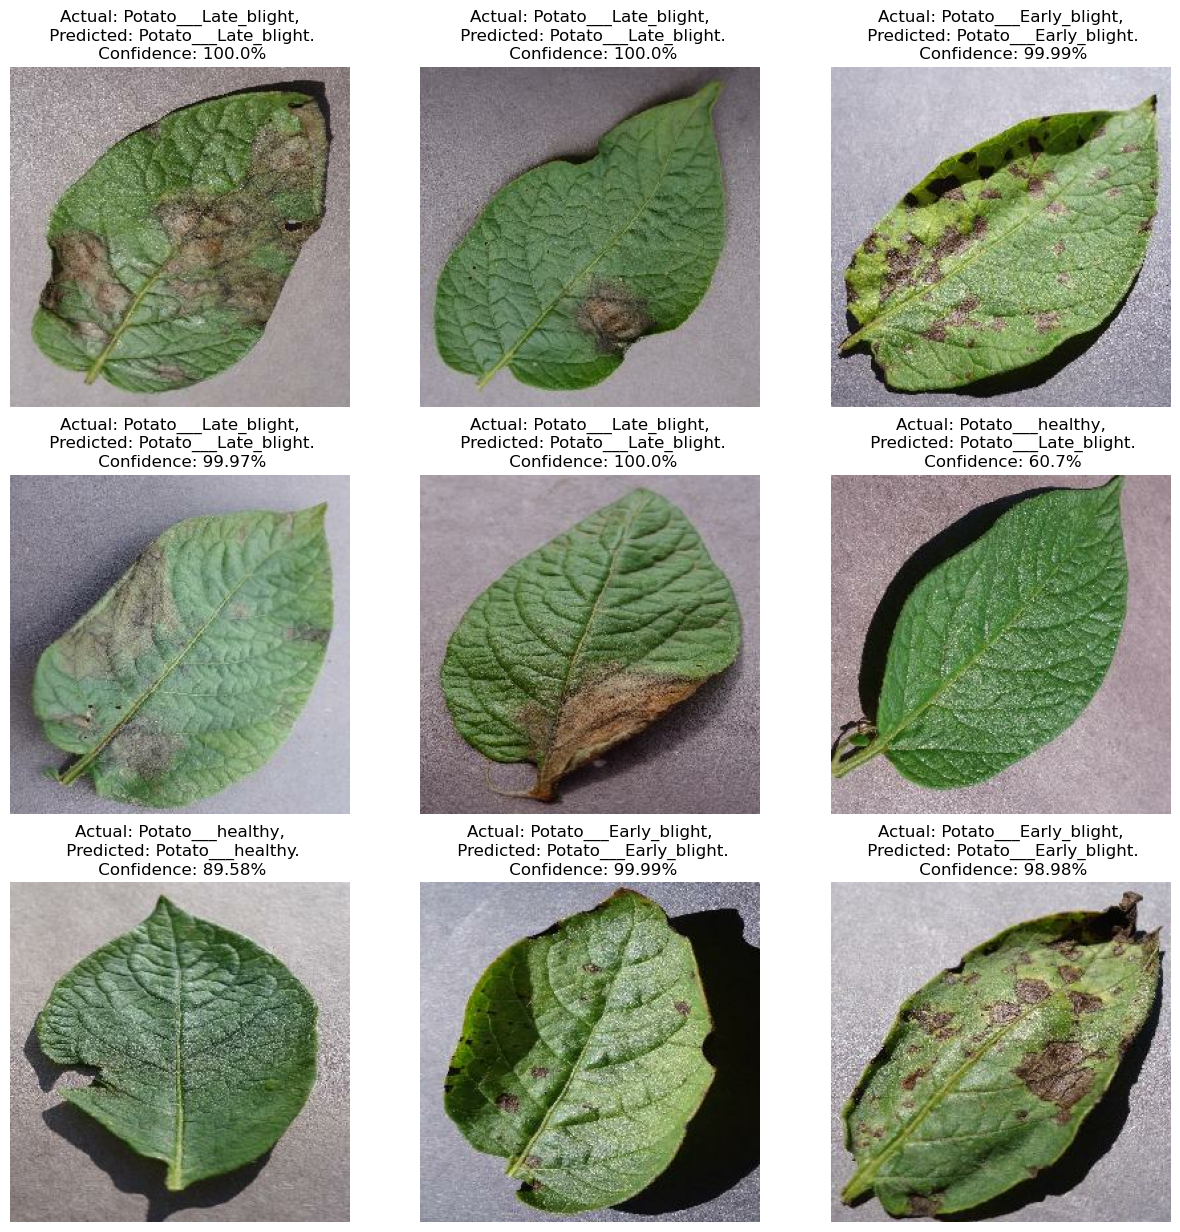

In [119]:


plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")




### Saving the Model

We append the model to the list of models as a new version

In [131]:
model_version=1

model.export(f"/Users/hirdeshpal/Jupiter Notebook/ML Algorithms/Deep Leaning/Project-potato-dieases/models/{model_version}")

INFO:tensorflow:Assets written to: /Users/hirdeshpal/Jupiter Notebook/ML Algorithms/Deep Leaning/Project-potato-dieases/models/1/assets


INFO:tensorflow:Assets written to: /Users/hirdeshpal/Jupiter Notebook/ML Algorithms/Deep Leaning/Project-potato-dieases/models/1/assets


Saved artifact at '/Users/hirdeshpal/Jupiter Notebook/ML Algorithms/Deep Leaning/Project-potato-dieases/models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5375882192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5375883776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5375882544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5375883072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5375883248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5375884128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5375883424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5375885008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5375884304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5375884656: TensorSpec(shape=(), dtype=tf.resource, 